# Grid price impact
## Value iteration

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numba import njit, prange

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
sns.set_palette("colorblind")

## Problem setup
We consider the price process given by
$$
\begin{aligned}
    S_{t+\Delta} &= S_{t} + \Delta\alpha_{t+\Delta} + \sigma\,[2\,B(a_t) - 1],\\
    \alpha_{t+\Delta} &= \alpha_t +  \sigma_\alpha\,[2\,B(\alpha_t)-1]\,,
\end{aligned}
$$
where $\Delta \alpha_{t+\Delta} =  \alpha_{t+\Delta} - \alpha_t$.

The inventory process $Q_t$ and the cash process $X_t$ are given by
$$
\begin{aligned}
    Q_{t+\Delta} &= Q_t + a_t\\
    X_{t+\Delta} &= X_{t} - a_t\,(S_t + \kappa\, a_t)
\end{aligned}
$$
with 
* $B(a_t) \sim \mathrm{Bern}(\sigma(b\,a_t))$,
* $B(\alpha_t) \sim \mathrm{Bern}(\sigma(-c\,a_t))$ 
* $a_t\in \{a_\text{min}, a_\text{min} + 1, \ldots, a_\text{max} - 1, a_\text{max}\}$ action at time $t$.

The return at time $T$ is given by
$$
    G_T = X_T + Q_T\,S_T - \beta\,Q_T^2 - \phi\,\sum_{t=1}^{T}Q^2_t.
$$
Then, the reward at time $t$ is given by
$$
    r_t = G_{t} - G_{t-1}  = - \kappa\,a^2_{t-1} + (Q_{t-1}+a_{t-1})\left(\Delta\alpha_{t}+ \sigma\,[2\,B(a_{t-1}) -1 ]\right) - 
    \beta\left(2\,Q_{t-1}\,a_{t-1} + a^2_{t-1}\right) - \phi\,Q^2_{t-1}
$$


To solve the problem in tabular form, we clip $S_t$ to a maximum and minimum value.

In [5]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_SIGNAL = 10 # max value of signal per side
MAX_INVENTORY = 10 # max inventory per side
MAX_ACTION = 10 # max buy and sell
DISCOUNT = 0.7

In [6]:
np.set_printoptions(linewidth=120, precision=4)

## For now the discretisations (in price and signal) are encoding the size of the sigmas

In [7]:
n_bins_signal = 101
n_bins_price = 501
bins_signal = np.linspace(-MAX_SIGNAL, MAX_SIGNAL, n_bins_signal)
bins_price = np.linspace(0, MAX_PRICE, n_bins_price)

sigma_alpha = bins_signal[1] - bins_signal[0]
sigma = bins_price[1] - bins_price[0]

lattice_price = (bins_signal[None, :] + bins_price[:, None])
lattice_price[np.where((lattice_price < 0) | (lattice_price > MAX_PRICE))] = np.nan

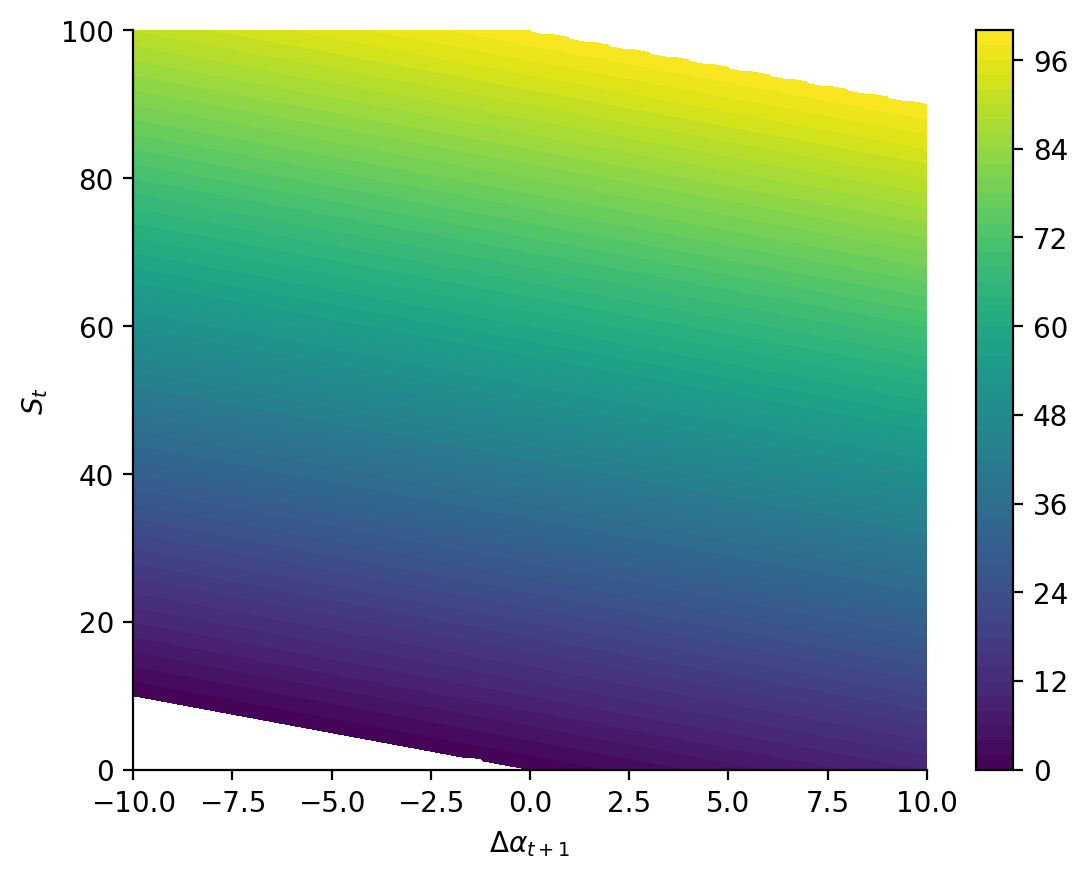

In [8]:
plt.contourf(bins_signal, bins_price, lattice_price, levels=50)
plt.ylabel(r"$S_t$")
plt.xlabel(r"$\Delta \alpha_{t+1}$")
plt.colorbar()
plt.show()

In [8]:
@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def signal_step_ix(ix):
    proba = sigmoid(-reversion_signal * bins_signal[ix])
    ix_jump_signal = 2 * np.random.binomial(1,proba) - 1 
    ix_next = ix + ix_jump_signal
    ix_next = clip(ix_next, 0, n_bins_signal - 1)
    return ix_next


@njit
def price_step_ix(action, ix_price, Delta_ix_signal, perm_price_impact):
    proba = sigmoid(perm_price_impact * action)
    ix_shift = 2 * np.random.binomial(1, proba) - 1
    ix_next = ix_shift + ix_price # impact by permanent price impact
    ix_next = ix_next + Delta_ix_signal # impact by signal
    ix_next = clip(ix_next, 0, n_bins_price - 1)
    return ix_next


def step_ix(
    ix_signal, ix_price, perm_price_impact, action
):
    ix_next_signal = signal_step_ix(ix_signal)
    Delta_ix_signal = ix_next_signal - ix_signal
    ix_next_price = price_step_ix(action, ix_price, Delta_ix_signal, perm_price_impact)

    return ix_next_signal, ix_next_price

In [9]:
from scipy.stats import multinomial, binom

In [10]:
perm_price_impact = 0.2
reversion_signal = 0.2

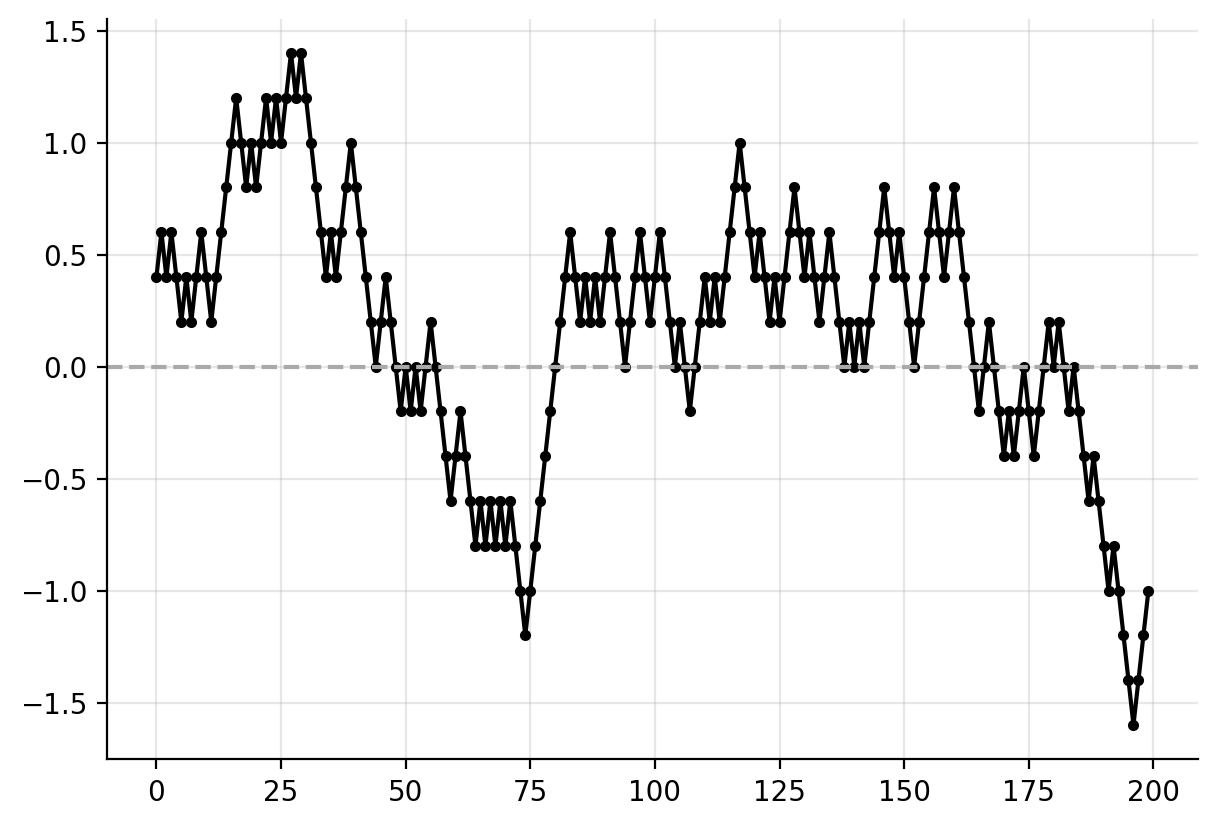

In [11]:
ix = int(n_bins_signal/2)
signal = bins_signal[ix]
nsteps = 200
signal_series = np.zeros(nsteps)

ix_next = ix+1
for n in range(nsteps):
    ix_next = signal_step_ix(ix_next)
    signal = bins_signal[ix_next]
    signal_series[n] = signal

fig, ax = plt.subplots(figsize=(6.4 * 1.1, 4.8))
plt.plot(signal_series, c="black", marker="o", markersize=3)
plt.axhline(y=0, c="darkgray", linestyle="--")
plt.grid(alpha=0.3)

In [12]:
def price_signal_series_deterministic_actions(
        actions,
        nsteps = 500,
        perm_price_impact = 0.01,
        seed = 100,
        ix_init_price = int(n_bins_price/2),ix_init_signal = int(n_bins_signal/2)):
    signal_series = np.zeros(nsteps)
    price_series = np.zeros(nsteps)
    
    price_series[0] = bins_price[ix_init_price]
    signal_series[0] = bins_signal[ix_init_signal]
    
    ix_signal = ix_init_signal
    ix_price = ix_init_price 

    for n in range(nsteps-1):
        action = actions[n]
        ix_signal, ix_price = step_ix(ix_signal, ix_price,
            perm_price_impact, action
        )
        signal = bins_signal[ix_signal]
        price = bins_price[ix_price]

        signal_series[n+1] = signal
        price_series[n+1] = price
    
    return price_series, signal_series

In [13]:
perm_price_impact = 0.01
reversion_signal = 0.2

nsteps = 500
seed = 31
actions = np.zeros(nsteps -1)

price_series, signal_series = price_signal_series_deterministic_actions(
        actions, nsteps = nsteps, perm_price_impact=perm_price_impact, seed = seed)

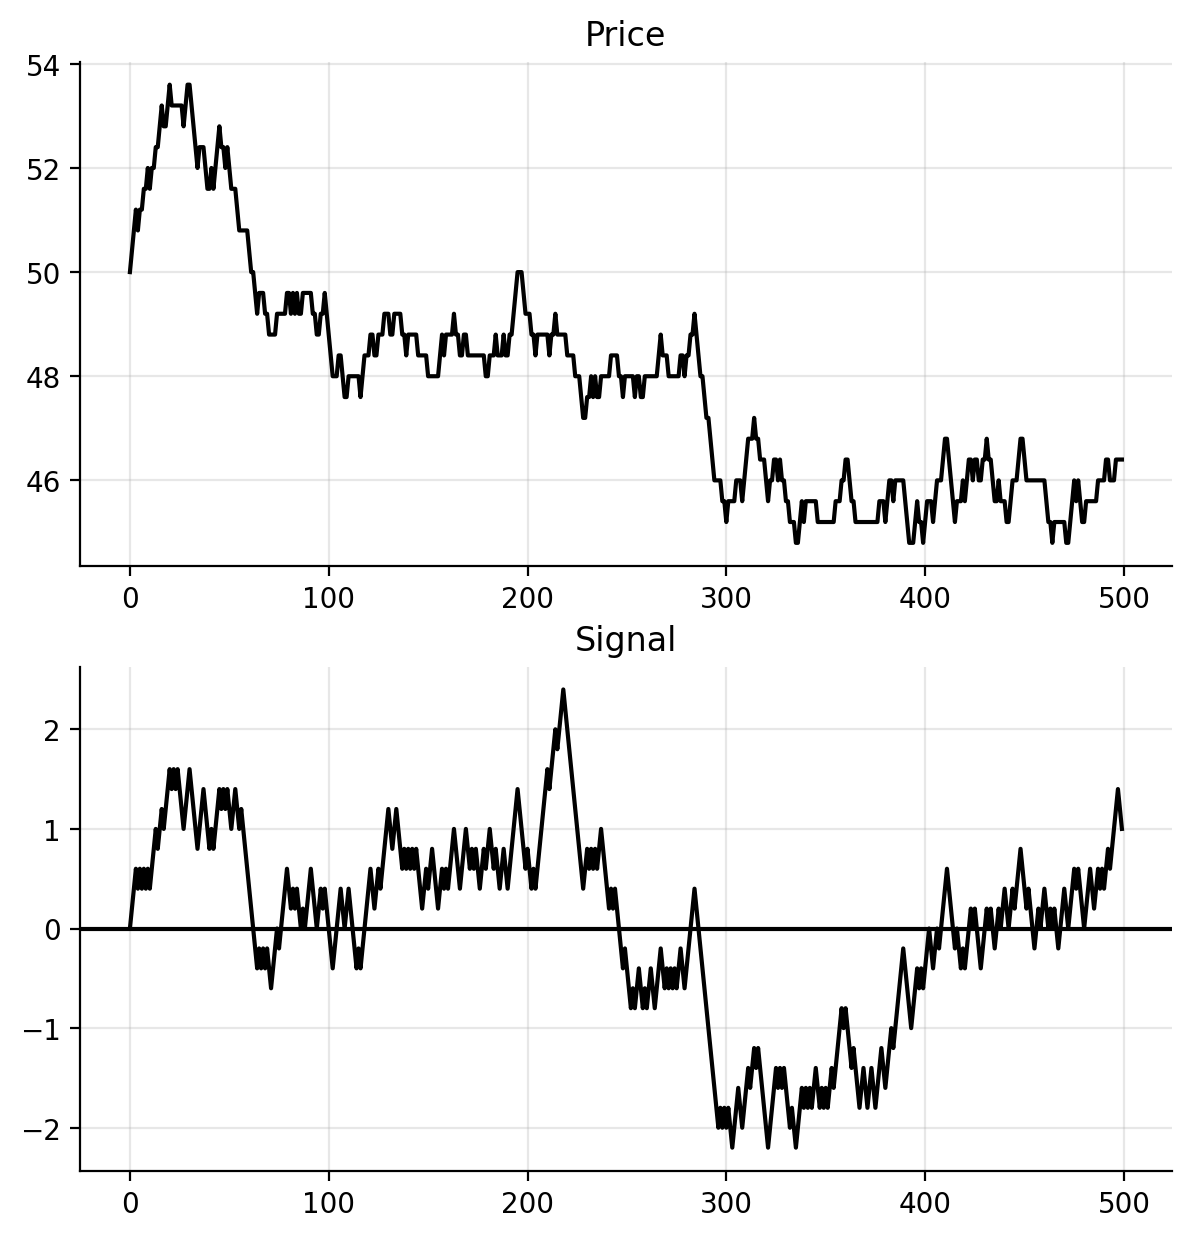

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(6.4 * 1.1, 4.8 * 1.5))
axs[0].plot(price_series, c="black")
axs[1].plot(signal_series, c="black")
axs[0].grid(alpha=0.3)
axs[1].grid(alpha=0.3)
axs[0].set_title("Price")
axs[1].set_title("Signal")
axs[1].axhline(y=0, c="black")
plt.show()

## Example: deterministic actions

## Only buy

In [15]:
seed = 31
nsteps = 300
actions = np.ones(nsteps)

price_impact_max = 0.5
n_price_impacts = 20

price_impacts = np.linspace(0, 1, n_price_impacts)
colors = plt.cm.viridis(price_impacts)

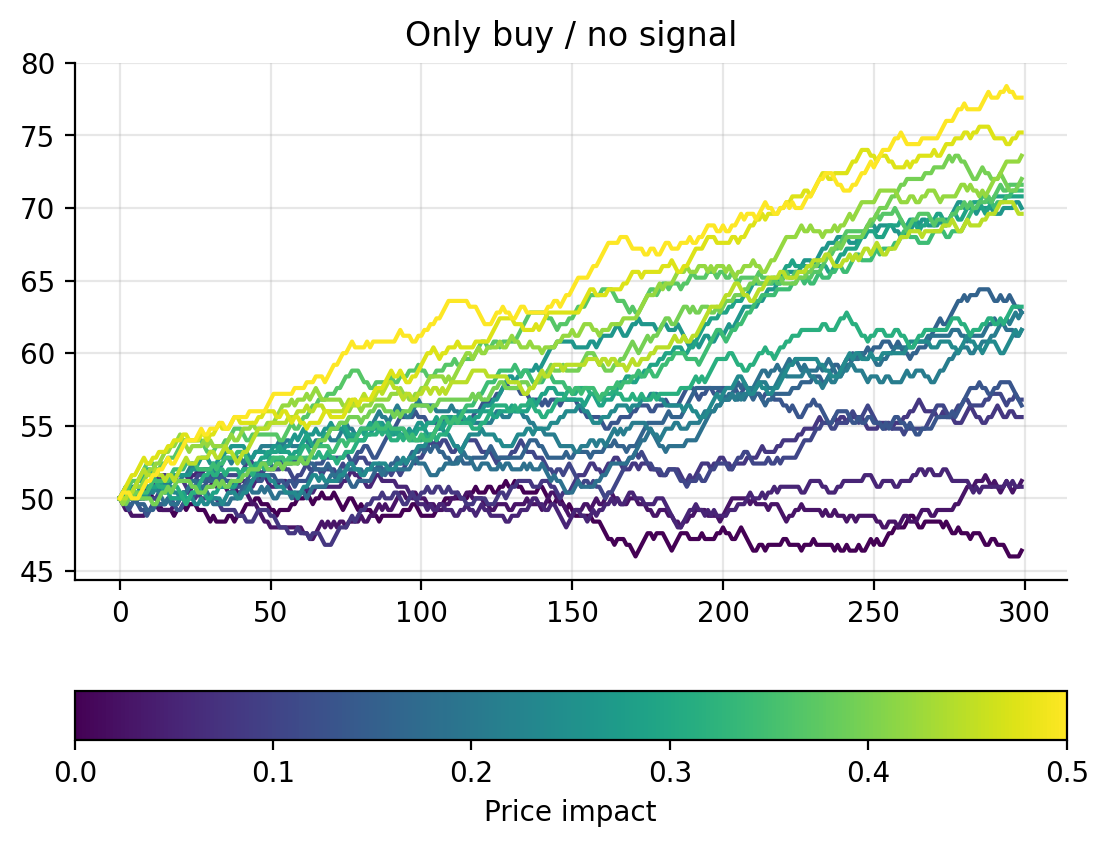

In [16]:
fig, ax = plt.subplots()

for color, perm_price_impact in zip(colors, price_impacts):
    prices, signals = price_signal_series_deterministic_actions(
        actions, nsteps = nsteps, perm_price_impact=perm_price_impact, seed = seed)
    ax.plot(prices, c=color)
    
ax.grid(alpha=0.3)
cnorm = mpl.colors.Normalize(0, price_impact_max)
mappable = mpl.cm.ScalarMappable(cnorm)
plt.title("Only buy / no signal")
fig.colorbar(mappable, ax=ax, orientation="horizontal", label="Price impact")
plt.show()

## Only sell

In [17]:
seed = 31
nsteps = 300
actions = -np.ones(nsteps)

price_impact_max = 0.5
n_price_impacts = 20

price_impacts = np.linspace(0, 1, n_price_impacts)
colors = plt.cm.viridis(price_impacts)

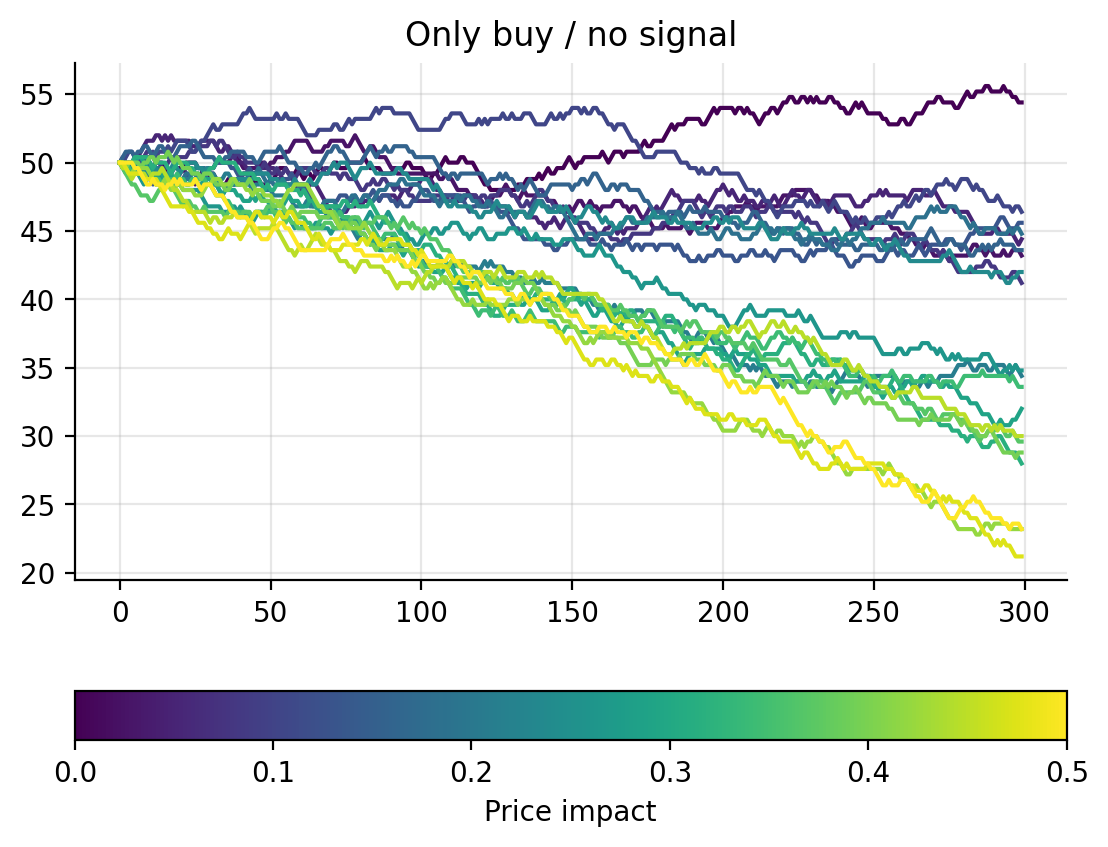

In [18]:
fig, ax = plt.subplots()

for color, perm_price_impact in zip(colors, price_impacts):
    prices, signals = price_signal_series_deterministic_actions(
        actions, nsteps = nsteps, perm_price_impact=perm_price_impact, seed = seed)
    ax.plot(prices, c=color)
    
ax.grid(alpha=0.3)
cnorm = mpl.colors.Normalize(0, price_impact_max)
mappable = mpl.cm.ScalarMappable(cnorm)
plt.title("Only buy / no signal")
fig.colorbar(mappable, ax=ax, orientation="horizontal", label="Price impact")
plt.show()

# Value iteration

Action-value function
$$
    q_\pi(s,\,a) = \sum_{s',\,r} p(s',\,r | s,\,a)[r + \gamma v(s')]
$$

# Optimal value function
The Bellman equation for the optimal value function satisfies
$$
    v_*(s) = \max_a\sum_{s',r}
    \underbrace{
        p(s',r | s, a)
    }_\text{MDP}
    [r + \gamma v_*(s')].
$$

If the Markov decision process (MDP) is known, i.e., $p(s', r \vert s, a)$,
then the optimal value function can be found by value iteration.

In the the next block, we define the components that describe the MDP for the price impact problem.
The state in this problem are:
(i) the observed price,
(ii) the latent signal, and
(iii) the inventory.

In [50]:
@njit
def bern_pmf(y, p):
    return p ** y * (1 - p) ** (1 - y)

@njit
def mdp(
    # t+1
    reward,
    price_next, signal_next, inventory_next,
    # t
    price, signal, inventory, 
    action,
    # parameters
    sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal
    
):
    """
    Markov decision process p(s',r | s, a) for the price impact problem.
    """
    
    # Probability price transition
    side = ( (price_next -  price - (signal_next - signal)) / sigma  ) / (2) + 1
    
    p_impact = sigmoid(action * perm_price_impact)
    pr_price = bern_pmf(side, p_impact) # either went up or down
    
    
    # Probability signal transition
    diff_signal =  signal_next -  signal  
    side_signal = ( diff_signal / sigma_alpha ) / (2) + 1
    p_signal = sigmoid( - signal * reversion_signal) # for now; later I would want this to react to the value of alpha_t
    pr_signal = bern_pmf(side_signal, p_signal)
    
    # Probability inventory transition
    pr_inventory = (inventory_next == inventory + action)
    
    # Probability reward
    pr_reward = (
        reward == ( 
            - temporary_price_impact * action **2
            + (inventory + action) * ( price_next - price )
            - running_inventory_penalty * inventory ** 2
        )
    )
    
    pr = pr_signal * pr_price * pr_inventory * pr_reward
    return pr

## The action-value function

$$
    q_\pi(s, a) = \sum_{s',r}p(s', r | s, a)[r + \gamma v(s')]
$$

In [51]:
@njit
def state_to_position(signal, inventory):
    """
    Transform state values to indices
    in the value-function array
    """
    signal_ix = (signal + MAX_SIGNAL).astype(np.int32)
    inventory_ix = int(inventory + MAX_INVENTORY)
    
    return signal_ix, inventory_ix



@njit
def action_value_function(
    signal, inventory, action, value_function,
    # parameters
    sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal
):
    
    action = float(action)
    #print('action is ',action)
    price_Blli_changes = sigma * np.array([+1.0, -1.0])
    #print('signal is ',signal)
    signals_new = signal + sigma_alpha * np.array([+1.0, -1.0])
    signals_new = clip(signals_new, -MAX_SIGNAL, MAX_SIGNAL)
    #print('signals_new is ',signals_new)
    signal_ix = np.maximum(np.digitize(signals_new, bins_signal) - 1,0)
    #print('signal_ix is ',signal_ix)
    
    #signals_new = bins_signal[signal_ix]
    inventory_new = inventory + action
    
    rewards = (
        - temporary_price_impact * action **2
        + (inventory + action) * ( signals_new - signal +  price_Blli_changes[None, :] )
        - running_inventory_penalty * inventory** 2
    )
    
    
    # p(s', r | s, a)
    mdp_values = mdp(
        reward = rewards, price_next = signals_new[:, None] - signal + price_Blli_changes[None, :], 
        signal_next = signals_new[:, None], inventory_next = inventory_new,
        price = 0., signal = signal, inventory = inventory, action = action,
        sigma = sigma, sigma_alpha = sigma_alpha, 
        perm_price_impact = perm_price_impact, temporary_price_impact = temporary_price_impact, 
        running_inventory_penalty = running_inventory_penalty,
        reversion_signal = reversion_signal
    )
    inventory_new = clip(inventory_new, -MAX_INVENTORY, MAX_INVENTORY)
    inventory_ix = int(inventory_new + MAX_INVENTORY)

    values = value_function[signal_ix, inventory_ix]
    mdp_values = mdp_values / mdp_values.sum() # renormalise
    value_est = mdp_values * (rewards + DISCOUNT * values[:, None])
    
    return value_est.sum()

In [52]:
values_signals = bins_signal.copy()
values_inventory = np.arange(-MAX_INVENTORY, MAX_INVENTORY + 1)
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)

In [53]:
value_function = np.zeros((
    len(bins_signal),
    2 * MAX_INVENTORY + 1,
))


action_value_function(
    signal=-10.0,
    inventory=-10.0,
    action=1,
    value_function = value_function,
    # parameters
    sigma = sigma, 
    sigma_alpha = sigma_alpha, 
    perm_price_impact = perm_price_impact, 
    temporary_price_impact = 1.0, 
    running_inventory_penalty = 0.01,
    reversion_signal = 0.2
)

-4.168852037119197

## Bellman equation for the optimal value function

$$
    v_*(s) = \max_a\sum_{s',r} p(s',r | s, a)[r + \gamma v_*s('s)]
$$

In [54]:
@njit
def value_iteration_state(
    signal, inventory, actions, value_function,
    # parameters
    sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal
):
    """
    Value iteration for a single given state
    """
    v_max = -np.inf
    action_max = np.nan
    
    for action in actions:
        new_inv = inventory + action
        if new_inv <=MAX_INVENTORY and new_inv>=-MAX_INVENTORY:
            value = action_value_function(
                signal = signal,
                inventory = inventory,
                action = action,
                value_function = value_function,
                # parameters
                sigma = sigma,
                sigma_alpha = sigma_alpha,
                perm_price_impact = perm_price_impact,
                temporary_price_impact = temporary_price_impact,
                running_inventory_penalty = running_inventory_penalty,
                reversion_signal = reversion_signal
            )
            #print('action is ', action, ' value is ', value)
            if value > v_max:
                v_max = value + 0.
                action_max = action
    
    return v_max, action_max

In [55]:
value_iteration_state(
    signal=-5.0,
    inventory=-7.0,
    actions = actions, # CHECK
    value_function = value_function,
    # parameters
    sigma = sigma, 
    sigma_alpha = sigma_alpha, 
    perm_price_impact = perm_price_impact, 
    temporary_price_impact = 1.0, 
    running_inventory_penalty = 0.01,
    reversion_signal = 0.02
  )

(-0.6298834498820634, 0.0)

In [56]:
@njit(parallel=True)
def value_iteration_single(
    signal_arr, inventory_arr, actions, value_function,
    # parameters
    sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal
):
    value_function_update = np.zeros_like(value_function, dtype=np.float64)
    actions_update = np.zeros_like(value_function, dtype=np.int32)
    
    for s_ix in prange(signal_arr.shape[0]):
        for i_ix in prange(inventory_arr.shape[0]):
            signal = signal_arr[s_ix]
            inventory = inventory_arr[i_ix]

            val, action = value_iteration_state(
                signal, inventory, actions, value_function,
                # parameters
                sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal
            )

            value_function_update[s_ix, i_ix] = val + 0. 
            actions_update[s_ix, i_ix] = action + 0.
    
    return value_function_update, actions_update

In [57]:
@njit
def value_iteration(
    signal_arr, inventory_arr, actions, value_function_init,
    # parameters
    sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal,
    err_max, max_it=50,
):
    
    value_function = value_function_init.copy()
    errs_hist = []
    for i in range(max_it):
        value_function_new, action_function = value_iteration_single(
            signal_arr=signal_arr,
            inventory_arr=inventory_arr,
            actions=actions,
            value_function=value_function,
            #parameters
            sigma = sigma,
            sigma_alpha = sigma_alpha,
            perm_price_impact=perm_price_impact,
            temporary_price_impact=temporary_price_impact,
            running_inventory_penalty=running_inventory_penalty,
            reversion_signal = reversion_signal
        )
        errs = np.abs(value_function - value_function_new)
        value_function = value_function_new.copy()
        errs_hist.append(errs.max())
        if errs.max() <= err_max:
            break
    
    return value_function, action_function, np.array(errs_hist)

# Compute the Q funtion and the policy

In [106]:
%%time
value_function = np.random.rand(
    len(bins_signal),
    2 * MAX_INVENTORY + 1,
)
#np.zeros((len(bins_signal),2 * MAX_INVENTORY + 1,))

perm_price_impact = 0.02
temporary_price_impact = 0.05
running_inventory_penalty = 0.05
reversion_signal = 0.7

value_function, action_function, errs_hist = value_iteration(
    signal_arr=values_signals,
    inventory_arr=values_inventory,
    actions=actions,
    value_function_init=value_function,
    sigma = sigma,
    sigma_alpha = sigma_alpha,
    perm_price_impact=perm_price_impact,
    temporary_price_impact=temporary_price_impact, # 0.0
    running_inventory_penalty=running_inventory_penalty,
    reversion_signal = reversion_signal,
    err_max=0.1,
    max_it=200
);

CPU times: user 330 ms, sys: 40.4 ms, total: 371 ms
Wall time: 45.4 ms


Text(0.5, 1.0, '$\\Delta$ value function')

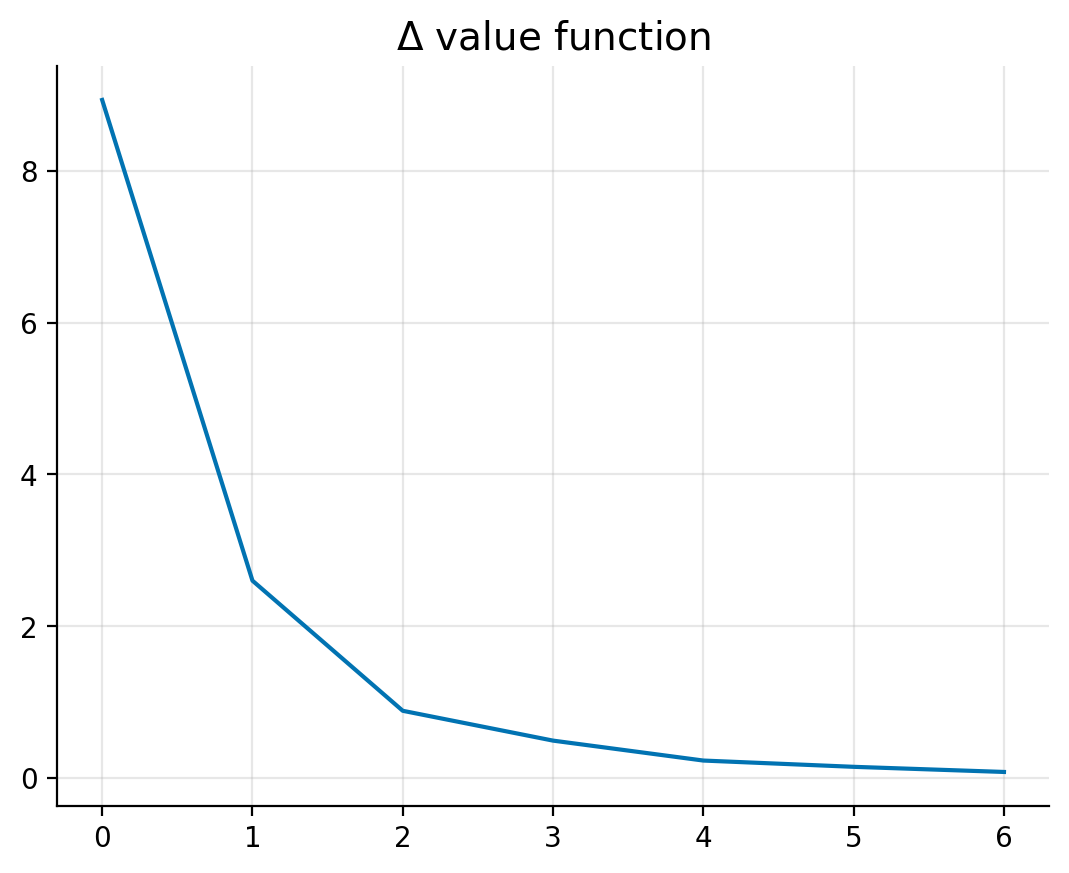

In [107]:
plt.plot(errs_hist)
plt.grid(alpha=0.3)
#plt.yscale('log')
plt.title(r"$\Delta$ value function", fontsize=14)

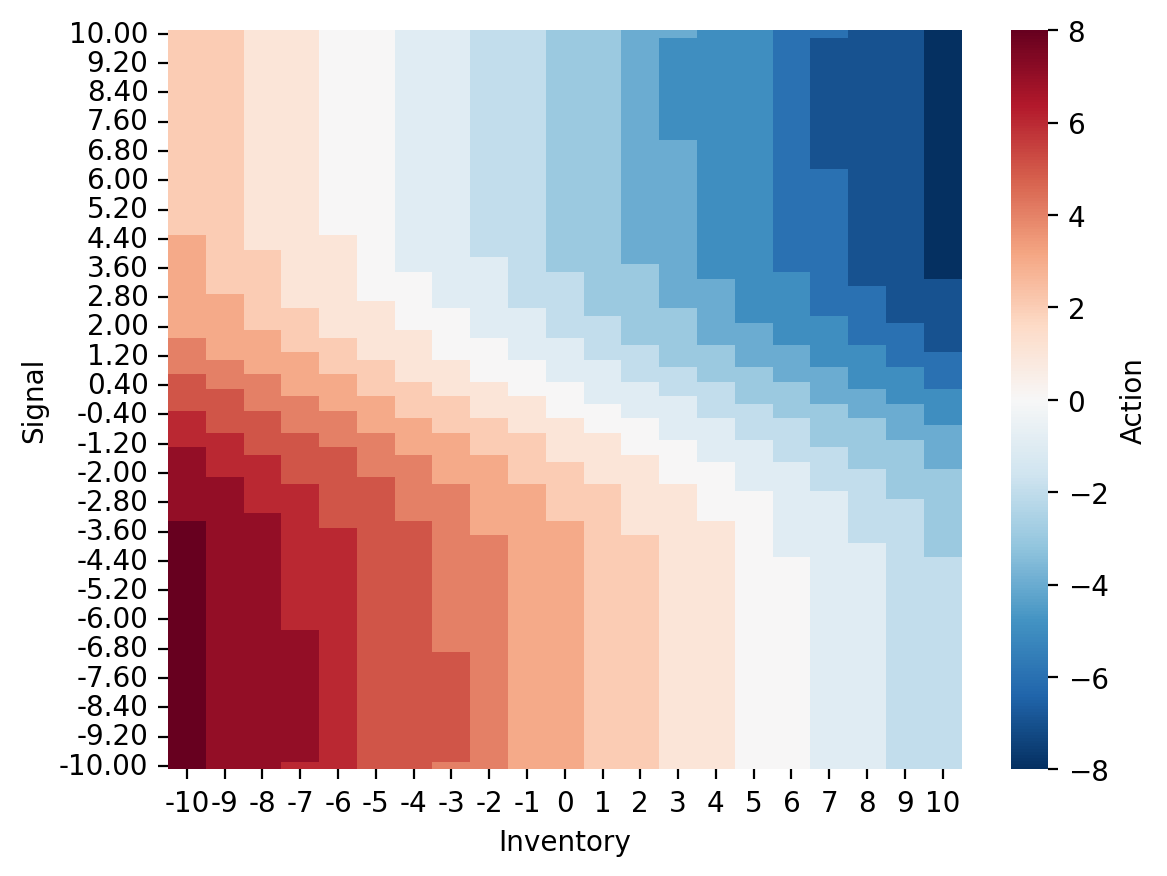

In [108]:
action_function_df = pd.DataFrame(
    action_function, index=values_signals, columns=values_inventory
)
ax = sns.heatmap(
    action_function_df, cmap="RdBu_r", center=0, cbar_kws={"label":"Action"},
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])

plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal")
plt.show()

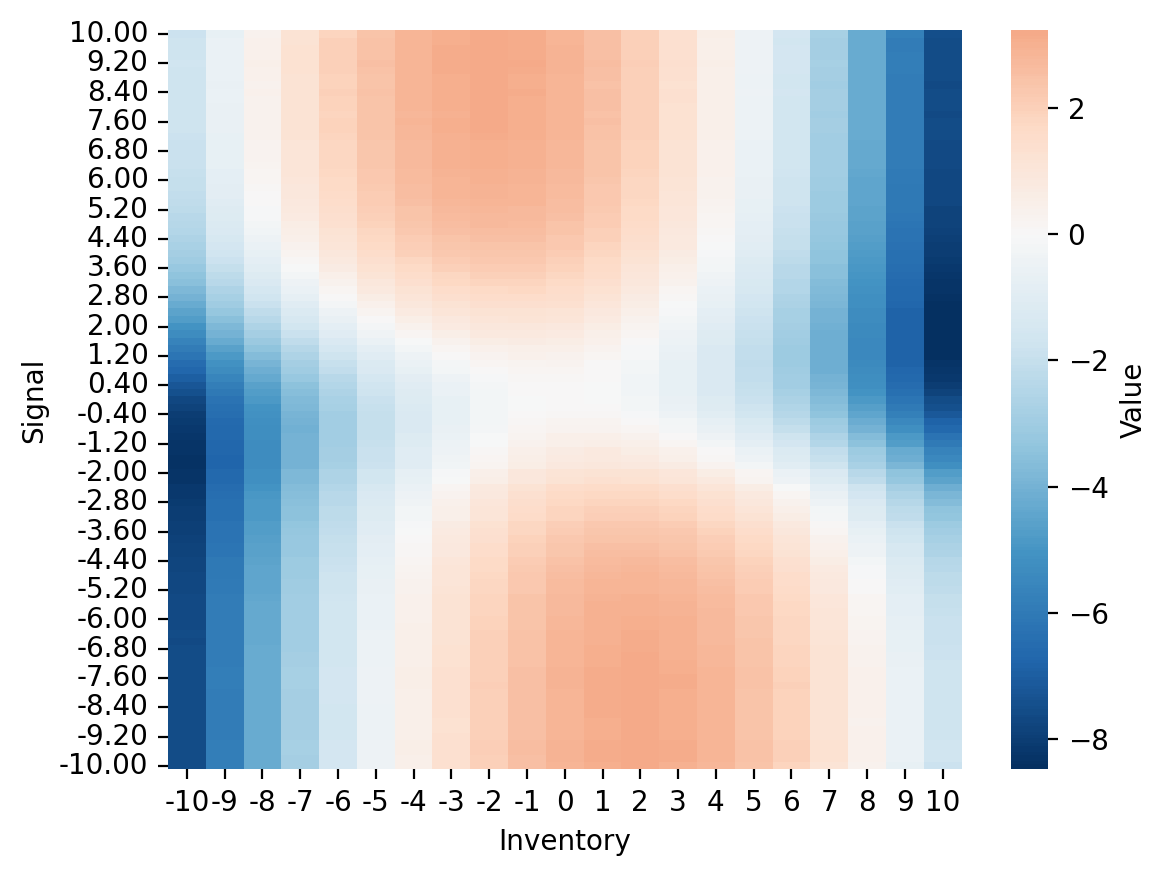

In [109]:
value_function_df = pd.DataFrame(value_function, index=values_signals, columns=values_inventory)
ax = sns.heatmap(
    value_function_df, cmap="RdBu_r", center=0.0, cbar_kws={"label": "Value"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])

plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal")
plt.show()

## Run a simulation

In [110]:
def price_step(price, signal, action, 
               #parameters
               sigma, sigma_alpha, perm_price_impact, temporary_price_impact, running_inventory_penalty, reversion_signal):
    pr_s = sigmoid(- signal * reversion_signal)
    signal_next = (
    signal + sigma_alpha * (2 * np.random.binomial(1,pr_s) - 1)
    )
    signal_next = clip(signal_next, -MAX_SIGNAL, MAX_SIGNAL)
     
    pr_p = sigmoid( action * perm_price_impact)
        
    price_next = price + (signal_next - signal) + sigma * ( 2. * np.random.binomial(1,pr_p) - 1 )
    price_next = clip(price_next, 0.0, MAX_PRICE)
    return price_next, signal_next

In [119]:
signal = 0.0
price = 50
inventory = 0
cash = 0

steps = 200
price_hist = np.zeros(steps)
action_hist = np.zeros(steps)
reward_hist = np.zeros(steps)
inventory_hist = np.zeros(steps)
cash_hist = np.zeros(steps)
signal_hist = np.zeros(steps)

np.random.seed(3141)
for t in range(steps):
    signal_ix = np.maximum(np.digitize(signal, bins_signal) - 1, 0)
    #_, inventory_ix = state_to_position(np.array([signal]), inventory)
    inventory_ix = inventory + MAX_INVENTORY
    action = action_function[signal_ix, inventory_ix].item()
    
    
    cash = cash - action * (price + temporary_price_impact * action)
    price_new, signal = price_step(
        price, signal, action, 
        # parameters
        sigma=sigma, sigma_alpha=sigma_alpha,
        perm_price_impact = perm_price_impact, temporary_price_impact = temporary_price_impact, 
        running_inventory_penalty = running_inventory_penalty, reversion_signal = reversion_signal
    )
    price_change, price = price_new - price, price_new
    inventory = inventory + action
    
    reward = (
        - temporary_price_impact * action **2
        + (inventory + action) * (  price_change )
        - running_inventory_penalty * inventory** 2
    )
    
    
    price = clip(price, 0.0, MAX_PRICE)
    inventory = clip(inventory, -MAX_INVENTORY, MAX_INVENTORY)
    
    signal_hist[t] = signal
    price_hist[t] = price
    action_hist[t] = action
    reward_hist[t] = reward
    inventory_hist[t] = inventory
    cash_hist[t] = cash

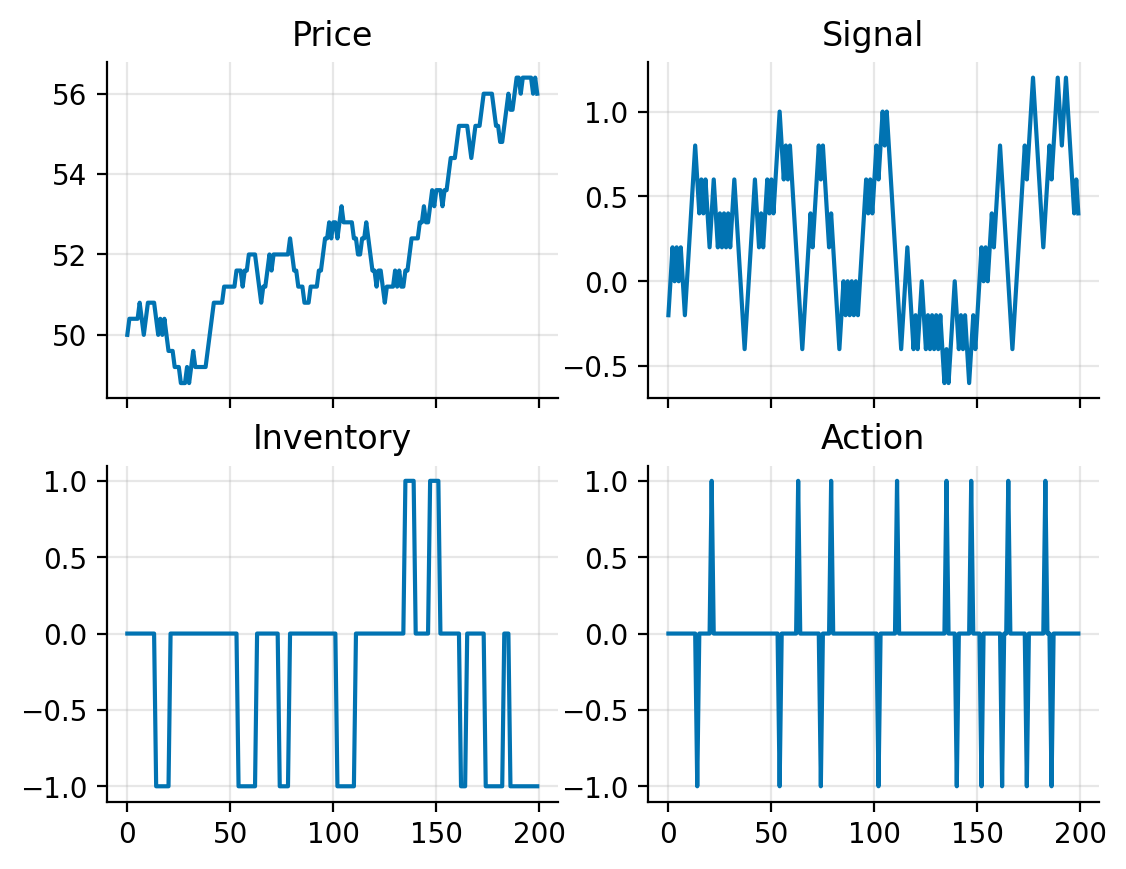

In [120]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

axs[0].plot(price_hist)
axs[1].plot(signal_hist)
axs[2].plot(inventory_hist)
axs[3].plot(action_hist)

labels = ["Price", "Signal", "Inventory", "Action"]
for ax, label in zip(axs, labels):
    ax.grid(alpha=0.3)
    ax.set_title(label)

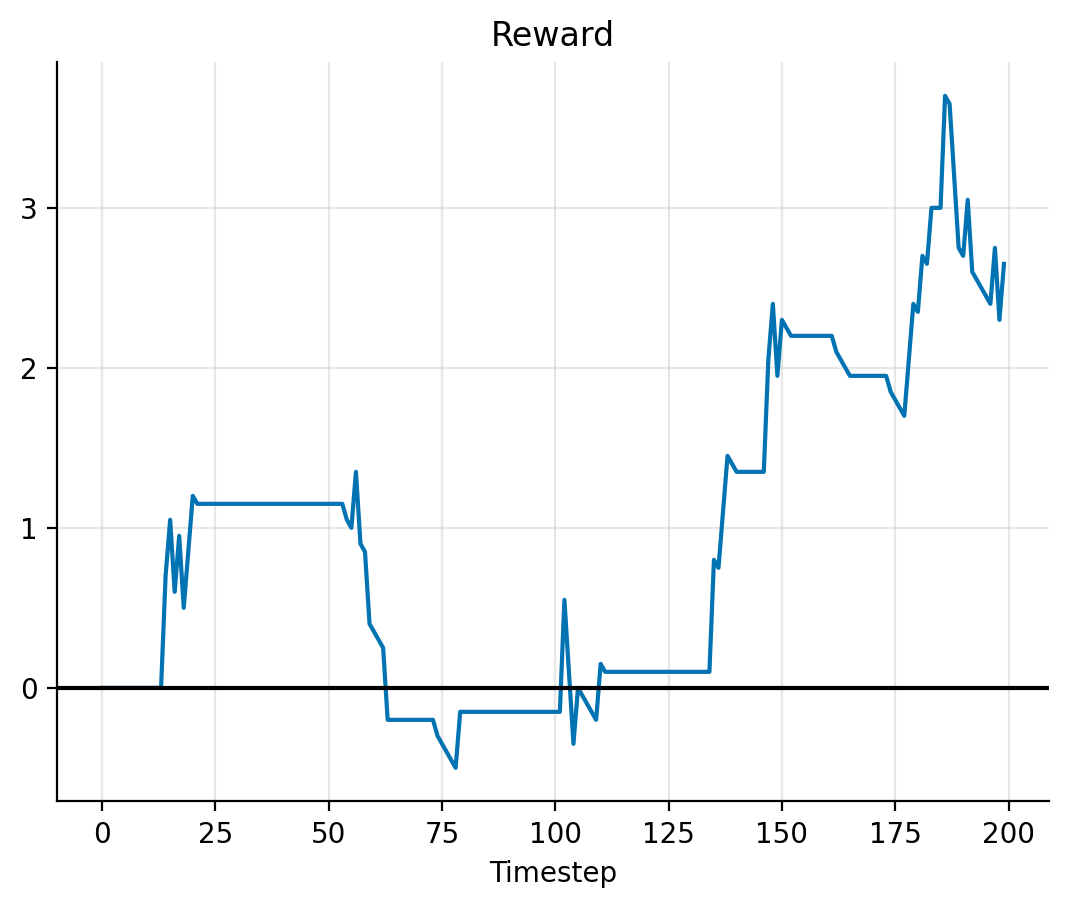

In [122]:
plt.plot(reward_hist.cumsum())
plt.title("Reward")
plt.xlabel("Timestep")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)